In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def optimize_cell_width():
    from IPython.display import display, HTML
    display(HTML("<style>.container { width:100% !important; }</style>"))

if __name__ == '__main__':
    optimize_cell_width()

In [4]:
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# %matplotlib notebook

In [4]:
!python -V

Python 3.10.9


# Training Data
## Download Data
#### `.obj` files

In [7]:
# !mkdir -p data/obj
# # only the first chunk
# !head -n1 data/obj_v00.txt | xargs -n 2 -P 8 sh -c 'wget --no-check-certificate $0 -O data/obj/$1'

#### Corresponding feat files

In [8]:
# !mkdir -p data/feat
# # only the first chunk
# !head -n1 data/feat_v00.txt | xargs -n 2 -P 8 sh -c 'wget --no-check-certificate $0 -O data/feat/$1'

## Some example shapes in ABC dataset

In [5]:
!ls data

00000050_80d90bfdd2e74e709956122a_features_000.yml  feat	  obj_v00.txt
00000050_80d90bfdd2e74e709956122a_step_000.step     feat_v00.txt  pcloud
00000050_80d90bfdd2e74e709956122a_trimesh_000.obj   obj		  step_v00.txt


In [6]:
DATA_DIR = pathlib.Path("./data/")

EX_STEP_PATH = "data/00000050_80d90bfdd2e74e709956122a_step_000.step"
EX_OBJ_PATH = "data/00000050_80d90bfdd2e74e709956122a_trimesh_000.obj"
# EX_OBJ_PATH = "data/obj/00008338/00008338_75b44178dbe14c99b75a0738_trimesh_008.obj"
EX_FEAT_PATH = "data/00000050_80d90bfdd2e74e709956122a_features_000.yml"
# EX_FEAT_PATH = "data/feat/00008338/00008338_75b44178dbe14c99b75a0738_features_008.yml"

In [5]:
def describe_mesh(mesh):
    print("# faces", mesh.face_number())
    print("# edges", mesh.edge_number())
    print("# vertices", mesh.vertex_number())

In [5]:
SAMPLE_K = 8096
MPL_FIG_SIZE = (10, 10)

def plot_point_cloud(matrix, ax=None, **kwargs):
    xs = matrix[:, 0]
    ys = matrix[:, 1]
    zs = matrix[:, 2]
    
    if ax is None:
        __, ax = plt.subplots(
            figsize=MPL_FIG_SIZE,
            subplot_kw=dict(projection="3d"),
        )

    ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))

    kwargs.setdefault("s", 1)
    ax.scatter(xs, ys, zs, **kwargs)
    return ax

TODO
- [x] *decide which to use to load .step file, blender or gmsh
  - blender does not support .step file by default
  - [x] *take a look at gmsh
  - [x] **but maybe using .obj + .feat is sufficient?**
    - looks feasible according to ABC paper
- [x] figure out how to iter through surfaces in a CAD model (loaded from a .obj file)
  - `pymeshlab` is promising
    - montecarlo (poisson disk bit slow although looked better)
- [x] figure out how to define ground truth from obj and/or feat.yaml file
  - YL: 'Nearest neighbour' in PIE paper probably meant using the vertices defined in feature file to find the 1-NN in sampled point cloud

In [8]:
import pymeshlab as pml

ms = pml.MeshSet()

ms.load_new_mesh(EX_OBJ_PATH)
ms.number_meshes()

1

In [9]:
mesh = ms.current_mesh()
describe_mesh(mesh)

# faces 44694
# edges 0
# vertices 22335


In [10]:
orig_points = mesh.vertex_matrix()
type(orig_points), len(orig_points)

(numpy.ndarray, 22335)

In [12]:
import random

sampled_orig_points = np.array(random.sample(list(orig_points), SAMPLE_K))
sampled_orig_points[:3]

array([[-12.026861,  -1.5875  , -27.774762],
       [ 14.615885,   0.      , -15.206102],
       [ 22.515627,  -3.175   ,   2.253286]])

<Axes3DSubplot: >

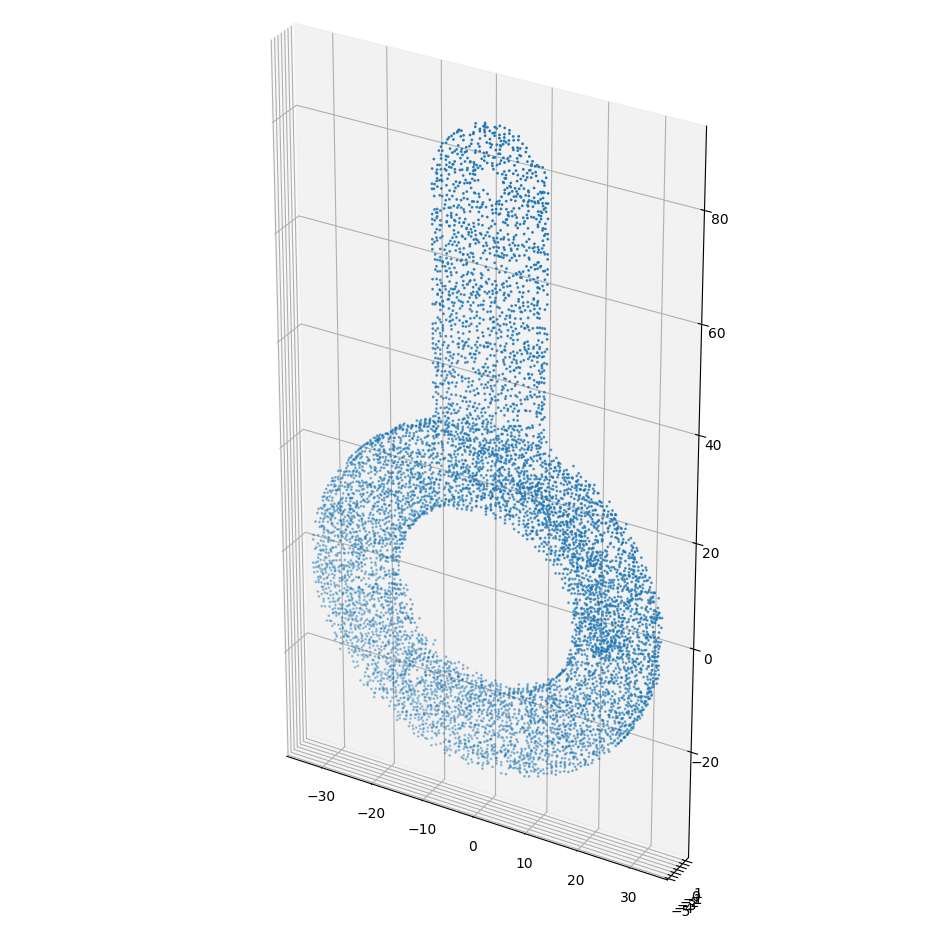

In [13]:
plot_point_cloud(sampled_orig_points)

### Sampling

In [14]:
%%time
ms.set_current_mesh(0)
ms.generate_sampling_poisson_disk(
    samplenum=SAMPLE_K,
    exactnumflag=True, # within 0.5% of samplenum, slower
)
ms.number_meshes()

CPU times: user 1.91 s, sys: 4.59 ms, total: 1.92 s
Wall time: 1.92 s


2

In [15]:
mesh_pc_pd = ms.current_mesh()
describe_mesh(mesh_pc_pd)

# faces 0
# edges 0
# vertices 8107


<Axes3DSubplot: >

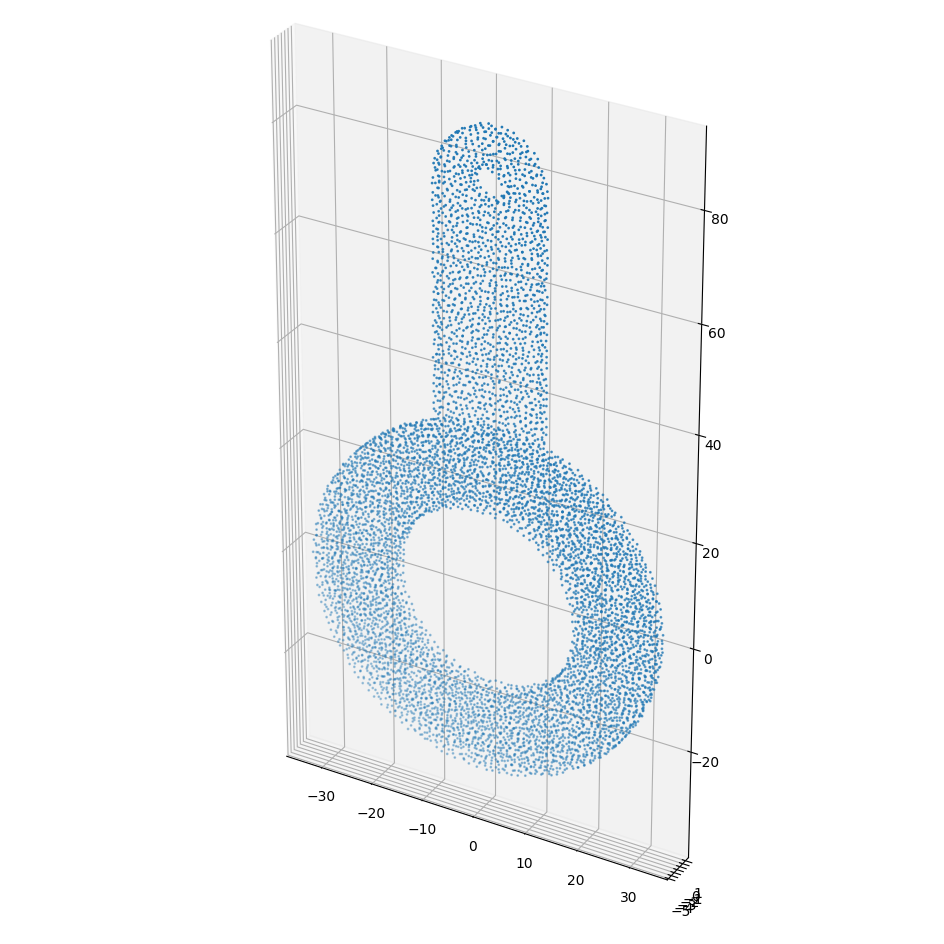

In [16]:
plot_point_cloud(mesh_pc_pd.vertex_matrix())

In [17]:
ms.set_current_mesh(0)
ms.generate_sampling_montecarlo(
    samplenum=SAMPLE_K,
)
ms.number_meshes()

3

In [18]:
mesh_pc_mc = ms.current_mesh()
describe_mesh(mesh_pc_mc)

# faces 0
# edges 0
# vertices 8096


<Axes3DSubplot: >

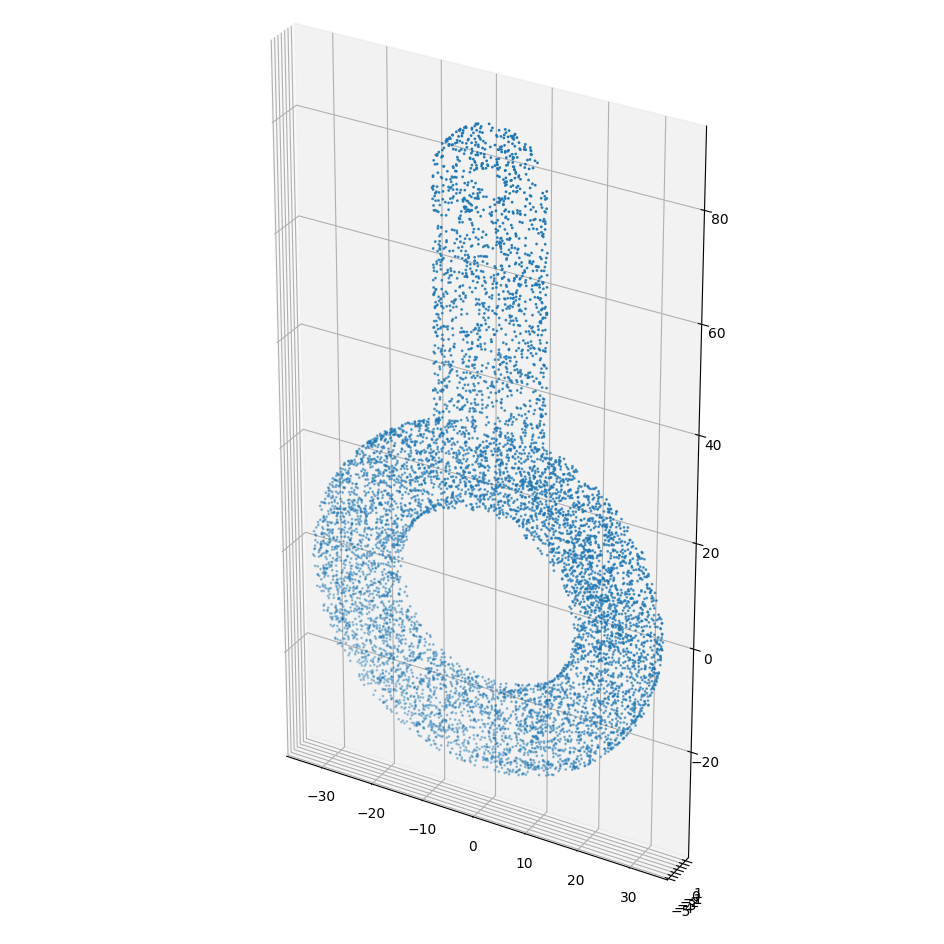

In [19]:
plot_point_cloud(mesh_pc_mc.vertex_matrix())

Q: Are MC sampled points different from orig vertices? YES for all

In [23]:
_orig_verts = pd.DataFrame(
    ms.mesh(0).vertex_matrix(),
    columns=["x", "y", "z"])
print(_orig_verts.shape)

_sampled_pts = pd.DataFrame(
    mesh_pc_mc.vertex_matrix(),
    columns=["x", "y", "z"])
print(_sampled_pts.shape)

_orig_verts.merge(_sampled_pts).shape

(22335, 3)
(8096, 3)


(0, 3)

### Sampling quick study (post-hoc)
TODO
- [x] :sample 1000 ABC models
- [x] run poissong disk
- [x] run MC
- [x] compare speed
- [x] compare some summary stats
  - [x] number of sampled points
  - [x] 1-nearest neighbor distance, mean/std (need to normalize metrics to compare cross different models)
    - normalized by range
- [x] compare some qualititive plots

In [18]:
import itertools
import random
import time

import training_data

random.seed(2023)


def sample_some_abc_obj_paths(n=1000):
    obj_dir_paths = [x for x in pathlib.Path('data/obj').iterdir() if x.is_dir()]
    obj_file_paths = itertools.chain.from_iterable(p.glob("*.obj") for p in obj_dir_paths)
    return random.sample(list(obj_file_paths), n)

sample_some_abc_obj_paths(3)

[PosixPath('data/obj/00004061/00004061_561b15139c044a0ba3e09633_trimesh_000.obj'),
 PosixPath('data/obj/00000969/00000969_1d5b44110bca4fa09dca0367_trimesh_000.obj'),
 PosixPath('data/obj/00006100/00006100_b6e075a7dd534de3be9c0300_trimesh_016.obj')]

In [19]:
def read_run_sampling(path, sampling="mc"):
    ms = training_data.read_obj(path)
    ms.set_current_mesh(0)
    
    t0 = time.time()

    if sampling == "mc":
        ms.generate_sampling_montecarlo(samplenum=training_data.N_SAMPLING_POINTS)
    elif sampling == "poisson-disk":
        ms.generate_sampling_poisson_disk(samplenum=training_data.N_SAMPLING_POINTS)
    elif sampling == "poisson-disk-strict":
        ms.generate_sampling_poisson_disk(samplenum=training_data.N_SAMPLING_POINTS, exactnumflag=True)
    else:
        raise ValueError(f"Unsupported sampling: {sampling}")

    t1 = time.time()
    seconds = t1 - t0

    pcloud = pd.DataFrame(
        ms.current_mesh().vertex_matrix(),
        columns=["x", "y", "z"]
    )
    return pcloud, seconds

In [20]:
sampled_abc_obj_paths = sample_some_abc_obj_paths(1000)

#### Speed of sampling

In [10]:
mc_pclouds, mc_times = [], []
for path in sampled_abc_obj_paths:
    pcloud, seconds = read_run_sampling(path, "mc")
    mc_pclouds.append(pcloud)
    mc_times.append(seconds)

sum(mc_times)

3.511359930038452

In [21]:
pdisk_pclouds, pdisk_times = [], []
for path in sampled_abc_obj_paths:
    pcloud, seconds = read_run_sampling(path, "poisson-disk")
    pdisk_pclouds.append(pcloud)
    pdisk_times.append(seconds)

sum(pdisk_times)

153.272803068161

In [25]:
strict_pdisk_pclouds, strict_pdisk_times = [], []
for path in sampled_abc_obj_paths:
    pcloud, seconds = read_run_sampling(path, "poisson-disk-strict")
    strict_pdisk_pclouds.append(pcloud)
    strict_pdisk_times.append(seconds)

sum(strict_pdisk_times)

1302.3615808486938

#### Visual comparison

In [6]:
def reload_sampled_pclouds(n, method):
    for i in range(n):
        path = f"data/sampling_study_{method}_pclouds/pc_{i}.parq"
        yield pd.read_parquet(path)

mc_pclouds_ = list(reload_sampled_pclouds(1000, "mc"))
strict_pdisk_pclouds_ = list(reload_sampled_pclouds(1000, "strict_pdisk"))

In [7]:
def compare_plots(mc_pcloud, pdisk_plcoud):
    __, axs = plt.subplots(1, 2, figsize=(20, 10), subplot_kw=dict(projection="3d"))

    plot_point_cloud(mc_pcloud.values, ax=axs[0])
    plot_point_cloud(pdisk_plcoud.values, ax=axs[1])

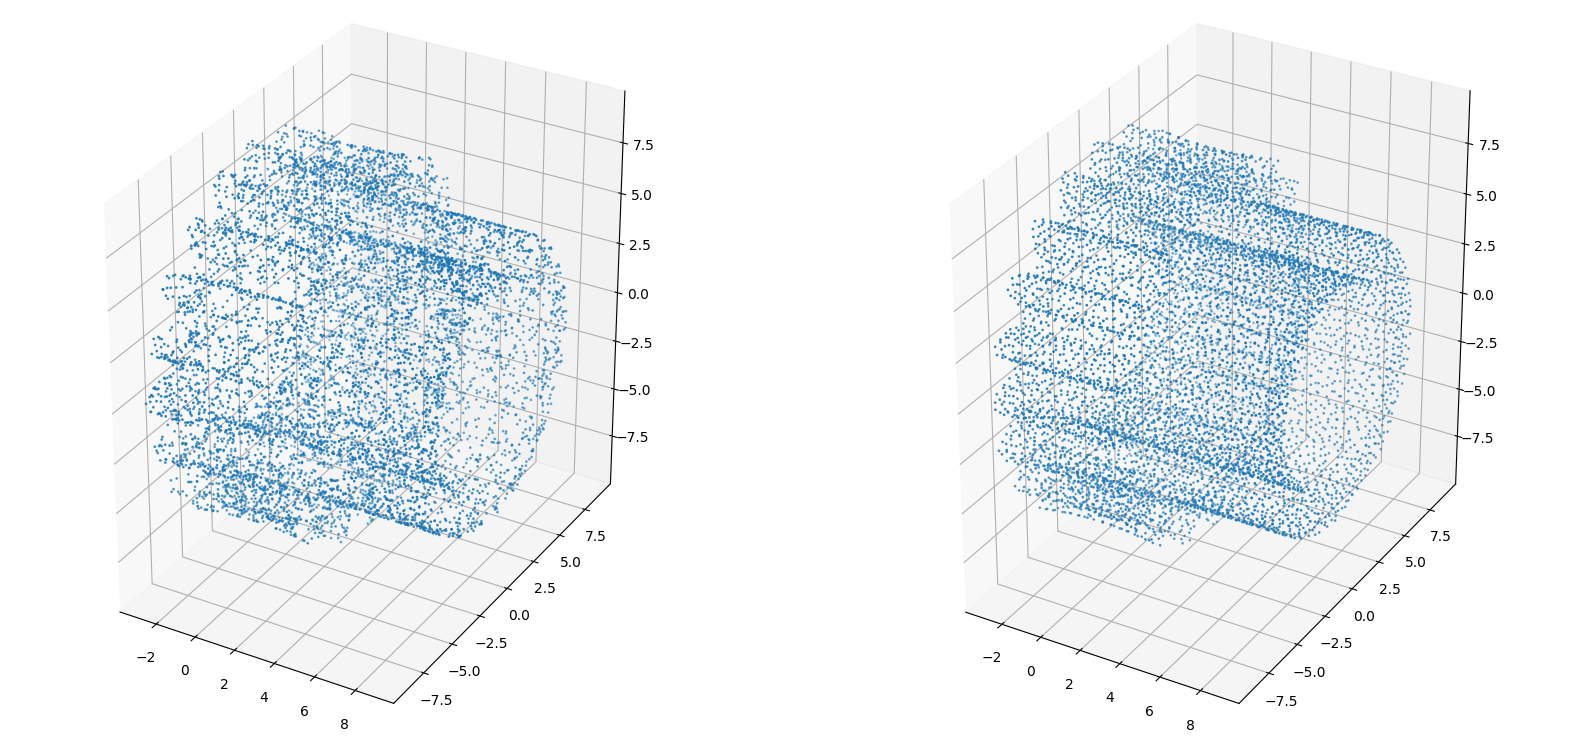

In [12]:
compare_plots(mc_pclouds_[0], strict_pdisk_pclouds_[0])

In [8]:
PCLOUD_IND = 871  # an example

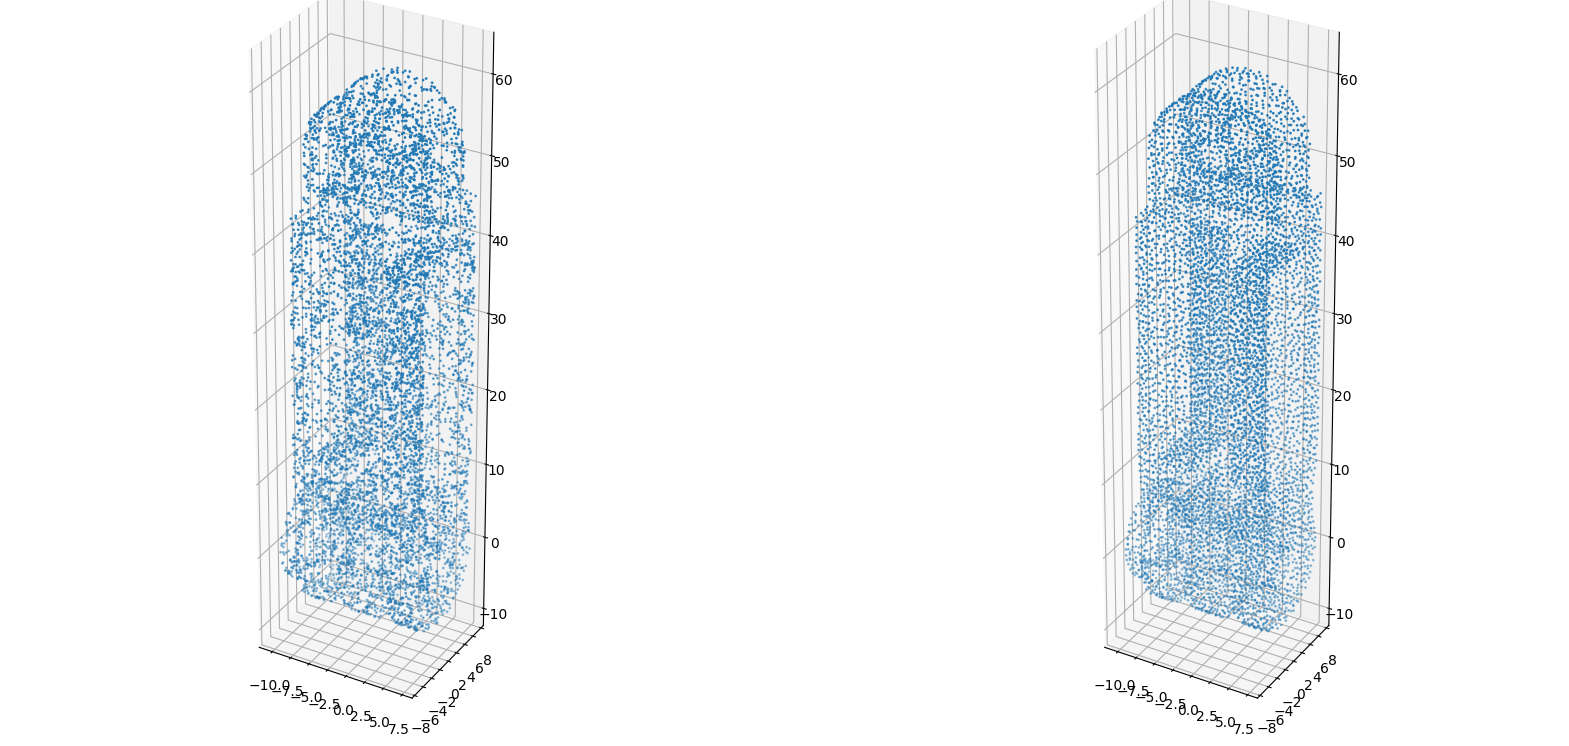

In [10]:
compare_plots(mc_pclouds_[PCLOUD_IND], strict_pdisk_pclouds_[PCLOUD_IND])

*Q*: Why do Poisson-Disk based point clouds show structural details better (than the MC based)?

*Discussion*: Point clouds sampled by the Poisson-Disk algorithm were less noisy, as shown by lower dispersions in the 1-NN summary stats below.
**In other words, the space distribution of points were more regular. This made [edges and corners, the irregulars,](https://cecas.clemson.edu/~stb/ece847/internal/classic_vision_papers/attneave_1954.pdf) stand out more.**
I would guess that PIE-NET perform better for point clouds sampled with Poisson-Disk.

#### Summary stats
##### # points

In [11]:
MC_SAMPLING = "MC"
PD_SAMPLING = "Poisson-Disk"
STRICT_PD_SAMPLING = "Poisson-Disk (strict)"

In [13]:
def number_of_points(pclouds):
    return pd.Series([len(df) for df in pclouds])

In [24]:
(
    pd.DataFrame({MC_SAMPLING: number_of_points(mc_pclouds_),
                  PD_SAMPLING: number_of_points(pdisk_pclouds), 
                  STRICT_PD_SAMPLING: number_of_points(strict_pdisk_pclouds_)})
        .mean()
)

MC                        8096.000
Poisson-Disk             11204.158
Poisson-Disk (strict)     8093.770
dtype: float64

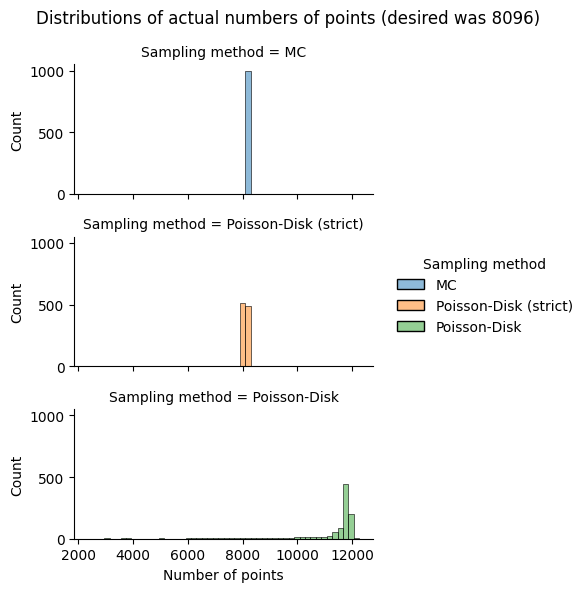

In [28]:
g = (
    pd.DataFrame({MC_SAMPLING: number_of_points(mc_pclouds_),
                  PD_SAMPLING: number_of_points(pdisk_pclouds), 
                  STRICT_PD_SAMPLING: number_of_points(strict_pdisk_pclouds_)})
        .melt(var_name="Sampling method", value_name="Number of points")
        .pipe((sns.displot, "data"), kind="hist", bins=50,
              aspect=2/1, height=2,
              x="Number of points",
              row="Sampling method", row_order=[MC_SAMPLING, STRICT_PD_SAMPLING, PD_SAMPLING],
              hue="Sampling method", hue_order=[MC_SAMPLING, STRICT_PD_SAMPLING, PD_SAMPLING],)
)
g.figure.suptitle(f"Distributions of actual numbers of points (desired was {SAMPLE_K})")
g.tight_layout()

##### 1nn distance

In [53]:
import multiprocessing


def _one_nn(row, orig_df):
    loo_df = orig_df[orig_df.x.ne(row.x) | orig_df.y.ne(row.y) | orig_df.z.ne(row.z)]
    assert len(loo_df) + 1 == len(orig_df), f"{len(loo_df)}, {len(orig_df)}"

    dist_vects = loo_df[["x", "y", "z"]].values - row[["x", "y", "z"]].values
    dist = np.square(dist_vects).sum(axis=1)
    return min(dist)


def add_1nn_dist(pcloud):
    pcloud["onn_dist"] = pcloud.apply(_one_nn, orig_df=pcloud, axis=1)
    return pcloud

# add_1nn_dist(mc_pclouds[1])
# mc_pclouds[1]

In [58]:
%%time
# pool = multiprocessing.Pool()

# mc_pclouds_ = pool.map(add_1nn_dist, mc_pclouds)

# pool.close()
"""
CPU times: user 2.03 s, sys: 865 ms, total: 2.89 s
Wall time: 11min 15s
"""

CPU times: user 2.03 s, sys: 865 ms, total: 2.89 s
Wall time: 11min 15s


In [136]:
# for i, pcloud in enumerate(mc_pclouds_):
#     pcloud.to_parquet(f"data/sampling_study_mc_pclouds/pc_{i}.parq")

pd.read_parquet("data/sampling_study_mc_pclouds/pc_879.parq")

x          y          z  onn_dist
0    -15.611121  -6.728531  17.109723  0.408492
1    -16.749911  -2.891023  11.833831  0.136547
2    -14.692706  12.044451  13.058854  0.061911
3    -11.982374  12.058281   2.019164  0.696135
4    -11.765042 -12.268765  20.001463  0.081269
...         ...        ...        ...       ...
8091  10.519037 -15.822375  16.116096  0.049521
8092   1.551757  18.935229   8.749249  0.562987
8093 -18.192789  -5.476991  16.030378  0.203146
8094  15.425762  -7.141873   2.918472  0.478043
8095  -9.523919  16.438664   2.285706  0.319912

[8096 rows x 4 columns]

In [70]:
# pool = multiprocessing.Pool()

# strict_pdisk_pclouds_ = pool.map(add_1nn_dist, strict_pdisk_pclouds)

# pool.close()

In [137]:
# for i, pcloud in enumerate(strict_pdisk_pclouds_):
#     pcloud.to_parquet(f"data/sampling_study_strict_pdisk_pclouds/pc_{i}.parq")

# pd.read_parquet("data/sampling_study_strict_pdisk_pclouds/pc_879.parq")

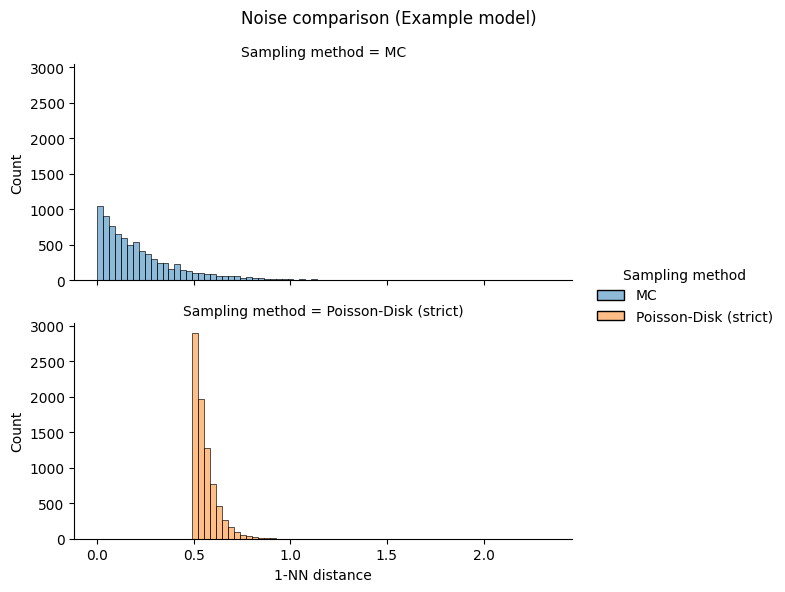

In [50]:
####### Distribution of 1NN distance for one model
g = (
    pd.DataFrame({MC_SAMPLING: mc_pclouds_[PCLOUD_IND].onn_dist,
                  STRICT_PD_SAMPLING: strict_pdisk_pclouds_[PCLOUD_IND].onn_dist
                 })
        .melt(var_name="Sampling method", value_name="1-NN distance")
        .pipe((sns.displot, "data"), kind="hist",
              aspect=2/1, height=3,
              x="1-NN distance", row="Sampling method", hue="Sampling method")
)
g.figure.suptitle(f"Noise comparison (Example model)")
g.tight_layout()

In [89]:
mc_pclouds_[PCLOUD_IND].onn_dist.std()

0.22669745809486208

In [95]:
strict_pdisk_pclouds_[PCLOUD_IND].onn_dist.std()

0.06035228222039655

In [40]:
###### Distribution of (normalized) dispersions of 1NN distances for 1000 models
mc_stds, spd_stds = [], []

for i in range(len(mc_pclouds_)):
    onn_dist_range = mc_pclouds_[i].onn_dist.max() - mc_pclouds_[i].onn_dist.min()
    # to normalize STDs of different models 

    mc_norm_std = mc_pclouds_[i].onn_dist.std() / onn_dist_range
    mc_stds.append(mc_norm_std)

    spd_norm_std = strict_pdisk_pclouds_[i].onn_dist.std() / onn_dist_range
    spd_stds.append(spd_norm_std)

len(mc_stds), len(spd_stds)

(1000, 1000)

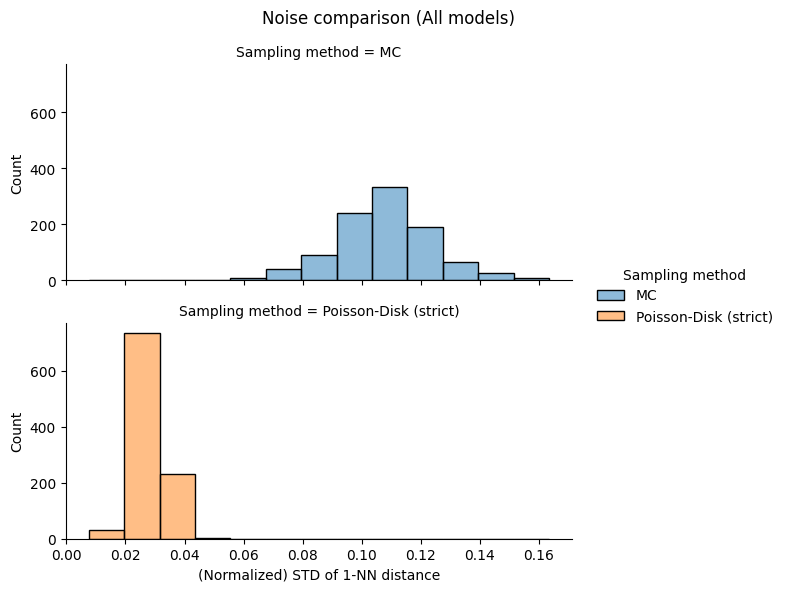

In [46]:
g = (
    pd.DataFrame({MC_SAMPLING: mc_stds, STRICT_PD_SAMPLING: spd_stds})
        .melt(var_name="Sampling method", value_name="(Normalized) STD of 1-NN distance")
        .pipe((sns.displot, "data"),
              x="(Normalized) STD of 1-NN distance", hue="Sampling method", row="Sampling method",
              aspect=2/1, height=3)
)
g.figure.suptitle("Noise comparison (All models)")
g.tight_layout()

## Check `feat.yaml`

In [25]:
import yaml

def read_yaml(path):
    with open(path, "r") as fi:
        content = yaml.safe_load(fi)
    return content

In [26]:
%%time
feat = read_yaml(EX_FEAT_PATH)
type(feat), len(feat)

CPU times: user 5.46 s, sys: 14 ms, total: 5.48 s
Wall time: 5.48 s


(dict, 2)

In [27]:
curves = feat['curves']
type(curves), len(curves)

(list, 106)

In [28]:
curv = pd.DataFrame(curves)
curv.shape

(106, 17)

In [29]:
curv

location     radius  sharp  \
0                                 [0.0, -3.175, 0.0]  17.514595   True   
1    [23.1470415124478, -3.175, -1.1967223111172498]   0.881972   True   
2                                 [0.0, -3.175, 0.0]  32.359504   True   
3                                                NaN        NaN  False   
4       [23.1470415124478, 0.0, -1.1967223111172498]   0.881972   True   
..                                               ...        ...    ...   
101           [-1.5875, -1.5875, 14.757469266853901]        NaN   True   
102                [1.5875, 132.118247598438, 21.59]        NaN  False   
103   [1.5875, 132.118247598438, 26.669999999999998]        NaN  False   
104  [-1.5875, 132.118247598438, 26.669999999999998]        NaN  False   
105               [-1.5875, 132.118247598438, 21.59]        NaN  False   

        type                                       vert_indices  \
0     Circle  [0, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81...   
1     Circle               [1, 191, 192, 193, 194, 195, 196, 1]   
2     Circle  [2, 197, 198, 199, 200, 201, 202, 203, 204, 20...   
3    BSpline                              [3, 418, 419, 420, 1]   
4     Circle               [3, 421, 422, 423, 424, 425, 426, 3]   
..       ...                                                ...   
101     Line             [68, 2161, 2162, 2163, 2164, 2165, 70]   
102     Line                         [64, 2166, 2167, 2168, 69]   
103     Line                         [63, 2169, 2170, 2171, 67]   
104     Line                         [65, 2172, 2173, 2174, 68]   
105     Line                         [66, 2175, 2176, 2177, 70]   

                                       vert_parameters           x_axis  \
0    [0.0, 51.92715129900495, 103.8543025980099, 15...  [1.0, 0.0, 0.0]   
1    [0.0, 897.5979010256578, 1795.1958020513157, 2...  [1.0, 0.0, 0.0]   
2    [0.0, 28.30263651882704, 56.60527303765407, 84...  [1.0, 0.0, 0.0]   
3    [-3.175, -2.3812499999999988, -1.5874999999999...              NaN   
4    [0.0, 897.5979010256578, 1795.1958020513157, 2...  [1.0, 0.0, 0.0]   
..                                                 ...              ...   
101  [-11.912530733146097, -11.065864066479431, -10...              NaN   
102  [130.53074759843798, 131.32449759843797, 132.1...              NaN   
103  [130.53074759843798, 131.32449759843797, 132.1...              NaN   
104  [130.53074759843798, 131.32449759843797, 132.1...              NaN   
105  [130.53074759843798, 131.32449759843797, 132.1...              NaN   

               y_axis            z_axis closed  continuity  degree  \
0    [-0.0, 0.0, 1.0]  [0.0, -1.0, 0.0]    NaN         NaN     NaN   
1    [-0.0, 0.0, 1.0]  [0.0, -1.0, 0.0]    NaN         NaN     NaN   
2    [-0.0, 0.0, 1.0]  [0.0, -1.0, 0.0]    NaN         NaN     NaN   
3                 NaN               NaN  False         6.0     1.0   
4    [-0.0, 0.0, 1.0]  [0.0, -1.0, 0.0]    NaN         NaN     NaN   
..                ...               ...    ...         ...     ...   
101               NaN               NaN    NaN         NaN     NaN   
102               NaN               NaN    NaN         NaN     NaN   
103               NaN               NaN    NaN         NaN     NaN   
104               NaN               NaN    NaN         NaN     NaN   
105               NaN               NaN    NaN         NaN     NaN   

                          knots  \
0                           NaN   
1                           NaN   
2                           NaN   
3    [-3.175, -3.175, 0.0, 0.0]   
4                           NaN   
..                          ...   
101                         NaN   
102                         NaN   
103                         NaN   
104                         NaN   
105                         NaN   

                                                 poles rational     weights  \
0                                                  NaN      NaN         NaN   
1                            

### Edge points

In [30]:
curve_point_idxs = curv.vert_indices.explode().astype(int)
curve_point_idxs.shape

(2319,)

In [31]:
print("Orig # points:", len(orig_points))
curve_point_idxs.describe()

Orig # points: 22335


count    2319.000000
mean     1024.452781
std       659.430097
min         0.000000
25%       438.500000
50%      1018.000000
75%      1597.500000
max      2177.000000
Name: vert_indices, dtype: float64

In [32]:
curve_point_idxs.sort_values().diff().describe()
# idx starts from 0 and increments by 1 at most, i.e. continous

count    2318.000000
mean        0.939172
std         0.239067
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: vert_indices, dtype: float64

Q: Max curve point index << # orig points; what gives? See PC plot below
- curve points had the smallest indices
- correctness of indices is also verified!

In [33]:
curve_points = orig_points[curve_point_idxs.drop_duplicates()]
curve_points.shape

(2178, 3)

<Axes3DSubplot: >

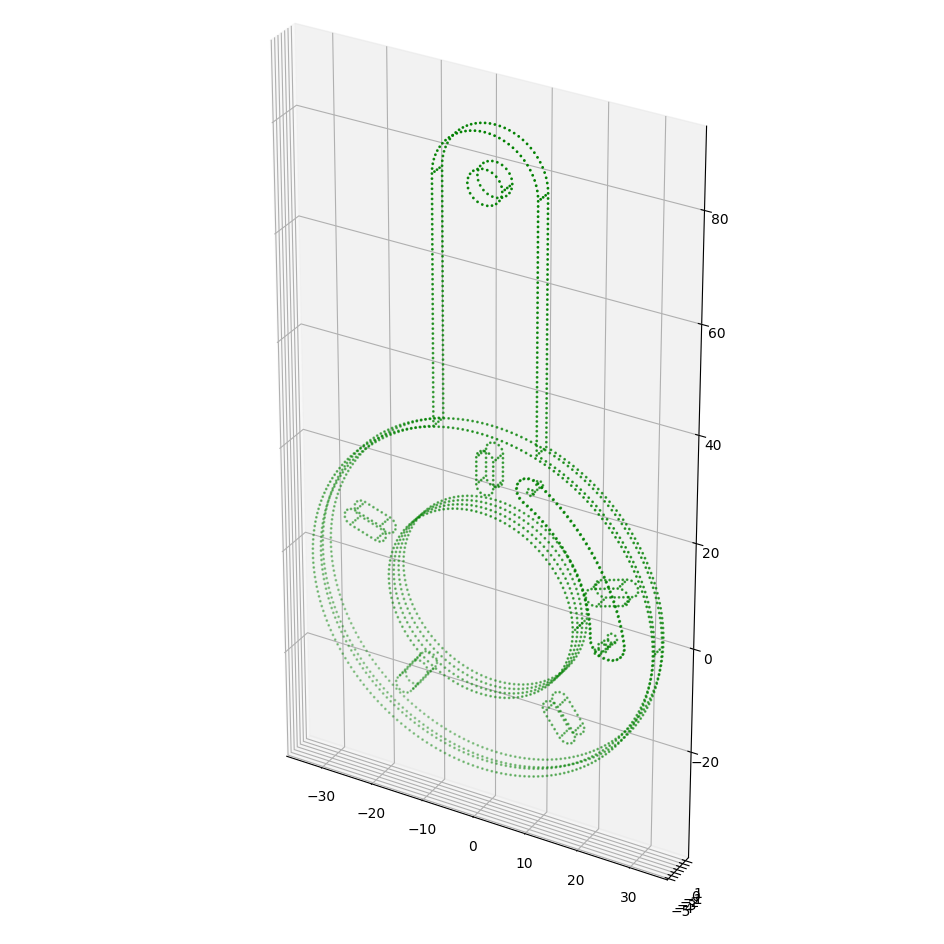

In [34]:
plot_point_cloud(curve_points, c="g")

Circle


<Axes3DSubplot: >

/home/yiqian/.virtualenvs/jupyter/lib/python3.10/site-packages/mpl_toolkits/mplot3d/proj3d.py:49: RuntimeWarning: divide by zero encountered in scalar divide
  dy /= ay


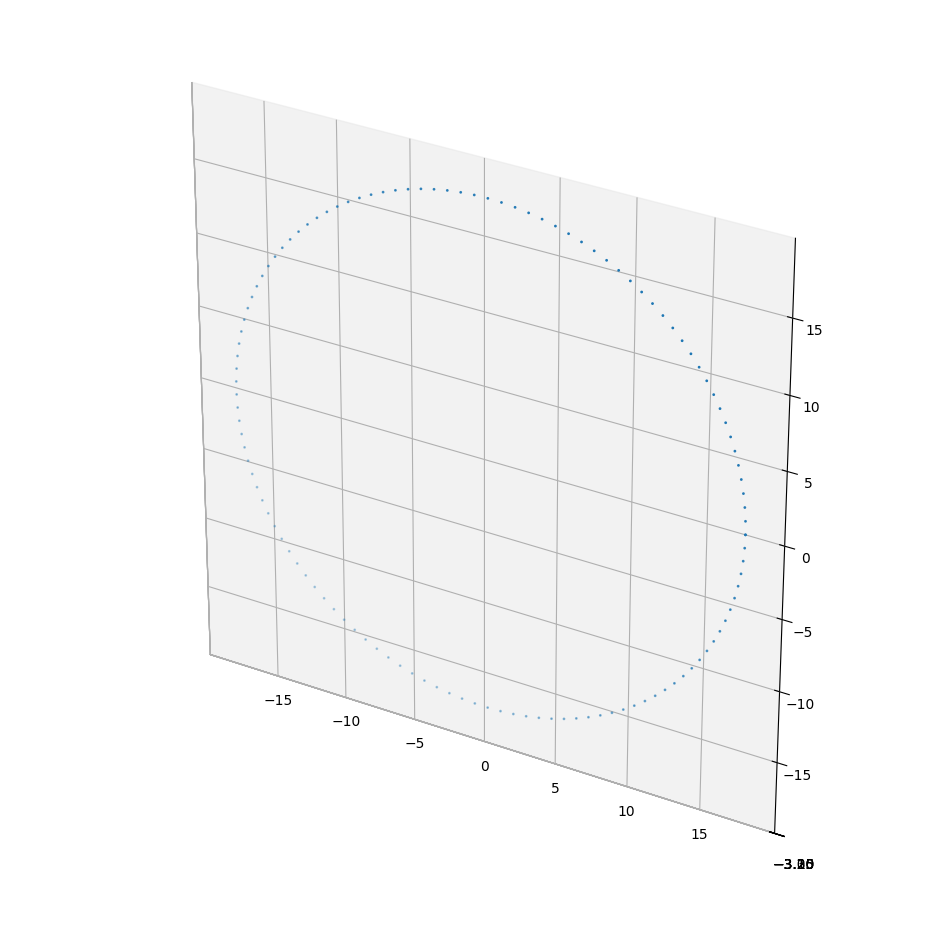

In [35]:
print(curv.loc[0, "type"])

one_curve_points = orig_points[pd.Series(curv.loc[0, "vert_indices"])]
plot_point_cloud(one_curve_points)

# one_curve_points_adjusted = orig_points[pd.Series(curv.loc[0, "vert_indices"])-1]
# plot_point_cloud(one_curve_points_adjusted)

### Corner points

In [36]:
curve_point_idxs.value_counts().value_counts().sort_index()
# having > 1 indicates corner points
# - correctness verified; see enhanced PC plot below

1    2107
2       1
3      70
Name: vert_indices, dtype: int64

In [37]:
def mark_corner(df: pd.DataFrame):
    idx_v_cnt = df.idx.value_counts()
    return df.assign(is_corner=df.idx.map(lambda i: idx_v_cnt.loc[i] > 1))

In [38]:
def merge_coords(df, orig_points):
    return df.assign(
        x=df.idx.map(lambda i: orig_points[i][0]),
        y=df.idx.map(lambda i: orig_points[i][1]),
        z=df.idx.map(lambda i: orig_points[i][2]),
    )

In [39]:
curve_pts = (
    curve_point_idxs
        .rename("idx").to_frame()
        .pipe(mark_corner)
        .pipe(merge_coords, orig_points=orig_points)
)
curve_pts.shape

(2319, 5)

In [40]:
curve_pts

idx  is_corner          x        y          z
0       0       True  17.514595 -3.17500   0.000000
0      71      False  17.490987 -3.17500   0.909074
0      72      False  17.420226 -3.17500   1.815698
0      73      False  17.302503 -3.17500   2.717427
0      74      False  17.138136 -3.17500   3.611830
..    ...        ...        ...      ...        ...
105    66       True  -1.587500  1.58750  21.590000
105  2175      False  -1.587500  0.79375  21.590000
105  2176      False  -1.587500  0.00000  21.590000
105  2177      False  -1.587500 -0.79375  21.590000
105    70       True  -1.587500 -1.58750  21.590000

[2319 rows x 5 columns]

In [41]:
corner_point_idxs = curve_pts.loc[curve_pts.is_corner ,"idx"]
corner_points = orig_points[corner_point_idxs.drop_duplicates()]
corner_points.shape

(71, 3)

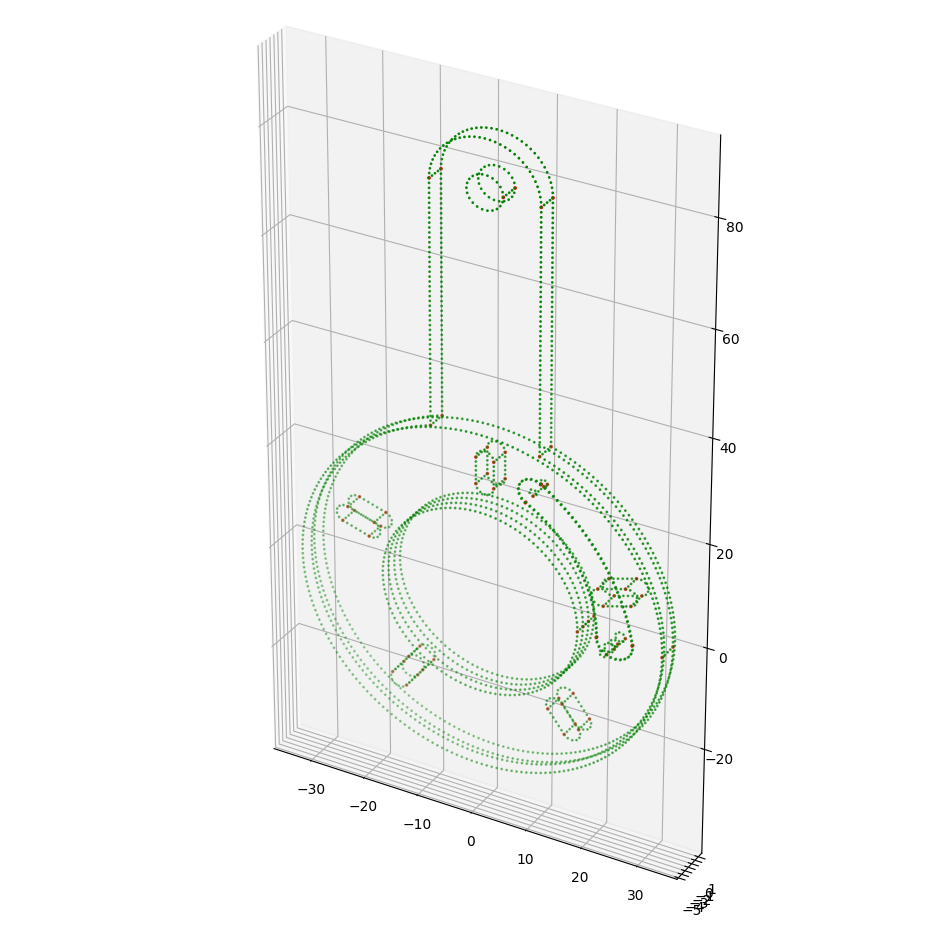

In [42]:
ax = plot_point_cloud(curve_points, c="g")
ax = plot_point_cloud(corner_points, ax=ax, s=3, c="r")

## Nearest Neighbour assignment/transfer for GT labels

In [43]:
sampled_pts = (
    pd.DataFrame(mesh_pc_mc.vertex_matrix(), columns=["x", "y", "z"])
)
sampled_pts.shape

(8096, 3)

In [44]:
sampled_pts

x         y          z
0     18.894685 -3.175000  21.644030
1      9.660469 -1.567514  64.576844
2    -28.639219  1.587500   6.412763
3    -22.924662  1.587500  11.477736
4     13.096624 -3.175000  17.996436
...         ...       ...        ...
8091  18.031881 -1.765300  12.664656
8092  -1.325399 -3.175000  18.039075
8093 -19.993418  0.000000 -14.660947
8094   2.921517 -1.587500  46.469706
8095  21.410528 -0.761546   5.287506

[8096 rows x 3 columns]

In [45]:
curve_pts

idx  is_corner          x        y          z
0       0       True  17.514595 -3.17500   0.000000
0      71      False  17.490987 -3.17500   0.909074
0      72      False  17.420226 -3.17500   1.815698
0      73      False  17.302503 -3.17500   2.717427
0      74      False  17.138136 -3.17500   3.611830
..    ...        ...        ...      ...        ...
105    66       True  -1.587500  1.58750  21.590000
105  2175      False  -1.587500  0.79375  21.590000
105  2176      False  -1.587500  0.00000  21.590000
105  2177      False  -1.587500 -0.79375  21.590000
105    70       True  -1.587500 -1.58750  21.590000

[2319 rows x 5 columns]

In [ ]:
# !pip install line_profiler

In [ ]:
%load_ext line_profiler

In [46]:
def transfer_gt_labels(sampled_pts, row: pd.Series):
    dist_vects = sampled_pts[["x", "y", "z"]].values - row[["x", "y", "z"]].values
    dist = np.square(dist_vects).sum(axis=1)
    return dist.argmin()

In [ ]:
%lprun -f transfer_gt_labels transfer_gt_labels(curve_pts.iloc[0], sampled_pts)

In [47]:
curve_pts = curve_pts.reset_index(drop=True)
curve_pts

idx  is_corner          x        y          z
0        0       True  17.514595 -3.17500   0.000000
1       71      False  17.490987 -3.17500   0.909074
2       72      False  17.420226 -3.17500   1.815698
3       73      False  17.302503 -3.17500   2.717427
4       74      False  17.138136 -3.17500   3.611830
...    ...        ...        ...      ...        ...
2314    66       True  -1.587500  1.58750  21.590000
2315  2175      False  -1.587500  0.79375  21.590000
2316  2176      False  -1.587500  0.00000  21.590000
2317  2177      False  -1.587500 -0.79375  21.590000
2318    70       True  -1.587500 -1.58750  21.590000

[2319 rows x 5 columns]

In [ ]:
# single process took:
"""
CPU times: user 7min 13s, sys: 253 ms, total: 7min 14s
Wall time: 7min 14s
"""

In [48]:
%%time
# default chunksize: 3.5min

import multiprocessing
import functools

find_nearest = functools.partial(transfer_gt_labels, sampled_pts)

curve_pts_ = curve_pts.drop_duplicates(subset=["idx"])
curve_df_rows = (row for __, row in curve_pts_.iterrows())

with multiprocessing.Pool() as pool:
    sampled_df_idxs = pool.map(find_nearest, curve_df_rows, chunksize=100)
type(sampled_df_idxs), len(sampled_df_idxs)

CPU times: user 134 ms, sys: 69.7 ms, total: 204 ms
Wall time: 582 ms


(list, 2178)

In [49]:
sampled_pts_ = (
    curve_pts_
        .assign(sampled_df_idx=sampled_df_idxs)
        .merge(sampled_pts,
               how="right",
               left_on="sampled_df_idx", right_index=True,
               suffixes=("_orig", None))
        .drop(columns=["idx", "sampled_df_idx"])
        .assign(is_edge=lambda df: df.is_corner.notna(),
                is_corner=lambda df: df.is_corner == True)
)
sampled_pts_.shape

(8725, 8)

In [51]:
def plot_edges_and_corners(pcloud_, ax=None):
    _edge_points = pcloud_.query("is_edge == True")[["x", "y", "z"]].values
    ax = plot_point_cloud(_edge_points, ax=ax, c="g")

    _corner_ponits = pcloud_.query("is_corner == True")[["x", "y", "z"]].values
    ax = plot_point_cloud(_corner_ponits, ax=ax, s=5, c="r")
    return ax

<Axes3DSubplot: >

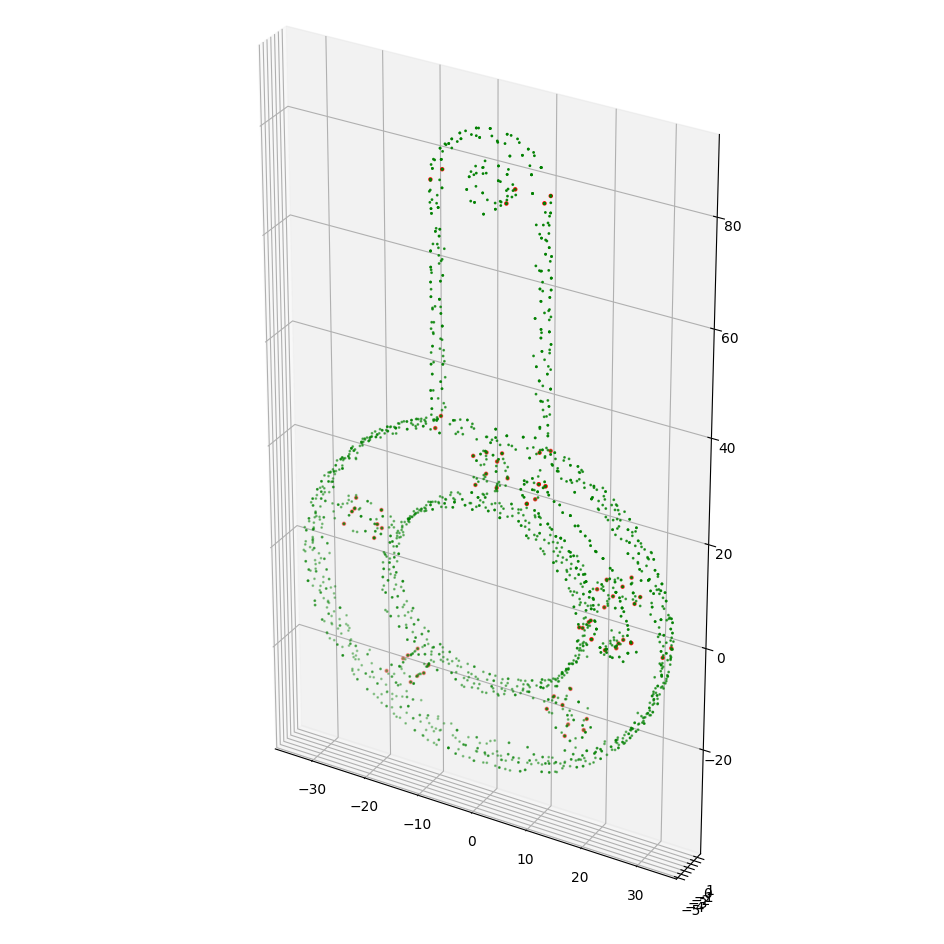

In [52]:
plot_edges_and_corners(sampled_pts_)

## Test training_data.py

In [54]:
import training_data

In [55]:
%%time
cad_model = training_data.read_obj(EX_OBJ_PATH)
feat = training_data.read_feat(EX_FEAT_PATH)

pcloud = training_data.sample_point_cloud(cad_model)

curv = training_data.mark_edges_and_corners(cad_model.mesh(0), feat)

pcloud_ = training_data.transfer_labels(curv, pcloud)

CPU times: user 4.5 s, sys: 13.5 ms, total: 4.51 s
Wall time: 4.51 s


In [56]:
pcloud_.sample(10)

curv_id  is_corner     x_orig  y_orig     z_orig          x         y  \
3151      NaN      False        NaN     NaN        NaN  15.549646 -3.175000   
4637      NaN      False        NaN     NaN        NaN  20.000805 -1.587500   
7816      NaN      False        NaN     NaN        NaN  30.536355  1.587500   
8479     81.0      False  -9.660469 -1.5875  52.771774  -9.660469 -1.042911   
2986     89.0      False -17.226126 -1.5875   3.165695 -17.204847 -1.820448   
6486      NaN      False        NaN     NaN        NaN  -8.320995  0.000000   
2378      NaN      False        NaN     NaN        NaN   2.828870  1.587500   
2694      NaN      False        NaN     NaN        NaN  13.708976  0.274131   
3624      NaN      False        NaN     NaN        NaN   3.485277  1.587500   
6066     93.0      False  20.037931 -1.5875  24.628110  20.405704 -1.253313   

              z  is_edge  
3151  12.537616    False  
4637   6.402191    False  
7816  -3.987803    False  
8479  53.290900     True  
2986   3.270051     True  
6486 -27.329552    False  
2378  80.971552    False  
2694  10.896529    False  
3624  47.149699    False  
6066  24.321792     True

In [58]:
pcloud_[pcloud_.curv_id.isin(pcloud_.curv_id.drop_duplicates().sample())]

curv_id  is_corner     x_orig  y_orig    z_orig          x         y  \
592      28.0      False  25.694737  1.5875  9.794293  25.319232  1.286787   
593      28.0       True  24.874113  1.5875  9.751285  25.319232  1.286787   
2162     28.0      False  26.874480  1.5875  8.732048  26.865837  1.587500   
2206     28.0      False  26.917487  1.5875  7.911423  26.911984  0.874881   
6763     28.0      False  26.426922  1.5875  9.421226  26.738083  1.587500   
8607     28.0       True  25.855242  1.5875  6.731681  26.460345  1.587500   
8608     28.0      False  26.544420  1.5875  7.179238  26.460345  1.587500   

             z  is_edge  
592   9.795238     True  
593   9.795238     True  
2162  9.191230     True  
2206  8.080176     True  
6763  9.456400     True  
8607  6.911018     True  
8608  6.911018     True

<Axes3DSubplot: >

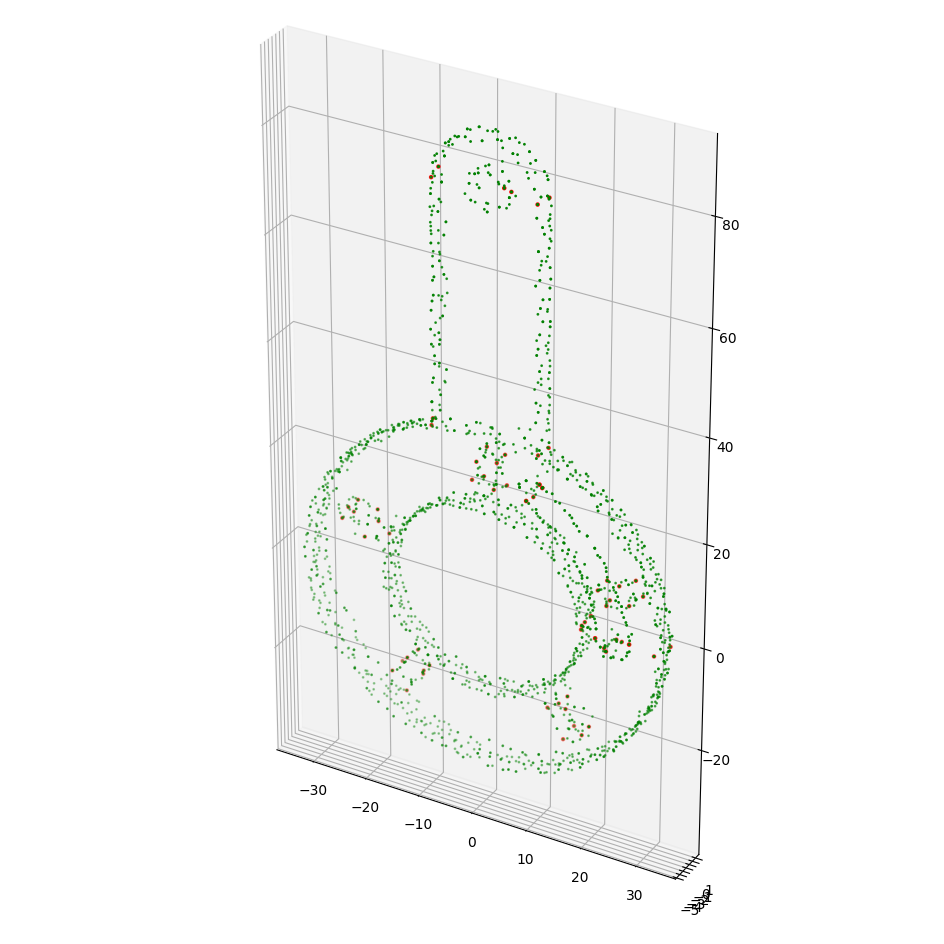

In [60]:
plot_edges_and_corners(pcloud_)

In [59]:
pcloud_

curv_id  is_corner     x_orig   y_orig     z_orig          x         y  \
0         2.0      False -27.792389 -3.17500  16.574697 -27.836548 -3.009686   
1         NaN      False        NaN      NaN        NaN   9.448389 -1.587500   
2        65.0      False -20.042746  0.79375   8.181479 -20.384307  0.000000   
3        65.0      False -20.042746  0.00000   8.181479 -20.384307  0.000000   
4         NaN      False        NaN      NaN        NaN -31.117907 -2.248258   
...       ...        ...        ...      ...        ...        ...       ...   
8706      NaN      False        NaN      NaN        NaN -10.898459 -1.587500   
8707      NaN      False        NaN      NaN        NaN  -5.975357 -1.587500   
8708      NaN      False        NaN      NaN        NaN  23.953081 -1.765300   
8709      NaN      False        NaN      NaN        NaN  11.885224  0.000000   
8710     92.0      False  13.687422  1.58750 -28.648159  13.898973  1.246815   

              z  is_edge  
0     16.499461     True  
1    -20.281359    False  
2      8.031261     True  
3      8.031261     True  
4      8.871678    False  
...         ...      ...  
8706 -20.764887    False  
8707  28.375082    False  
8708  -2.691960    False  
8709 -26.572545    False  
8710 -28.544894     True  

[8711 rows x 9 columns]

### Save pcloud

In [61]:
print(training_data._format_pcloud_filename(EX_FEAT_PATH))

00000050_pcloud_points.parq


In [63]:
# training_data.write_pcloud(pcloud_, EX_FEAT_PATH)

## EDA for feat files

Q: proportion of files with uncommon types of curves

In [64]:
def read_curve_type_stats(path) -> pd.Series:
    feat = training_data.read_feat(path)
    feat_info = pd.DataFrame(feat["curves"])

    return feat_info.type.value_counts()

In [65]:
%%time
read_curve_type_stats(EX_FEAT_PATH)

CPU times: user 1.11 s, sys: 0 ns, total: 1.11 s
Wall time: 1.11 s


Line       52
Circle     47
BSpline     7
Name: type, dtype: int64

In [232]:
FEAT_DIR = DATA_DIR / "feat"

feat_paths = sorted([path for path in FEAT_DIR.glob("**/*features*.yml")])
len(feat_paths)

7168

---
digress: matching obj files all exist?
YES

In [101]:
import re

def get_corresponding_obj_path(feat_path):
    path_id = feat_path.parent.name
    obj_paths = list((DATA_DIR / "obj" / path_id).glob("*.obj"))
    assert len(obj_paths) == 1, f"not 1-to-1 mapping for {path_id}"
    return obj_paths[0]

for feat_path in feat_paths:
    get_corresponding_obj_path(feat_path)

---
Info: **~30 min** to go over the entire feature yml files

In [66]:
# %%time
# with multiprocessing.Pool() as pool:
#     curve_type_stats = pool.map(read_curve_type_stats, feat_paths)
# len(curve_type_stats)

In [122]:
curtype = (
    pd.DataFrame(curve_type_stats)
        .reset_index(drop=True)
)
curtype.shape

(7168, 5)

In [126]:
curtype.notna().sum()

Circle     6183
Line       6042
BSpline    5747
Ellipse    1296
Other        19
dtype: int64

In [135]:
common_curtype = (
    curtype[curtype[["Ellipse", "Other"]].isna().all(axis=1)]
)
common_curtype.shape

(5863, 5)

## Generate point clouds

In [242]:
training_data.generate_one_pcloud(feat_paths[2])

Wrote pcloud to data/pcloud/00000004_pcloud_points.parq


In [243]:
loaded_pcloud = pd.read_parquet("data/pcloud/00000004_pcloud_points.parq")
loaded_pcloud.shape

(8189, 9)

<Axes3DSubplot: >

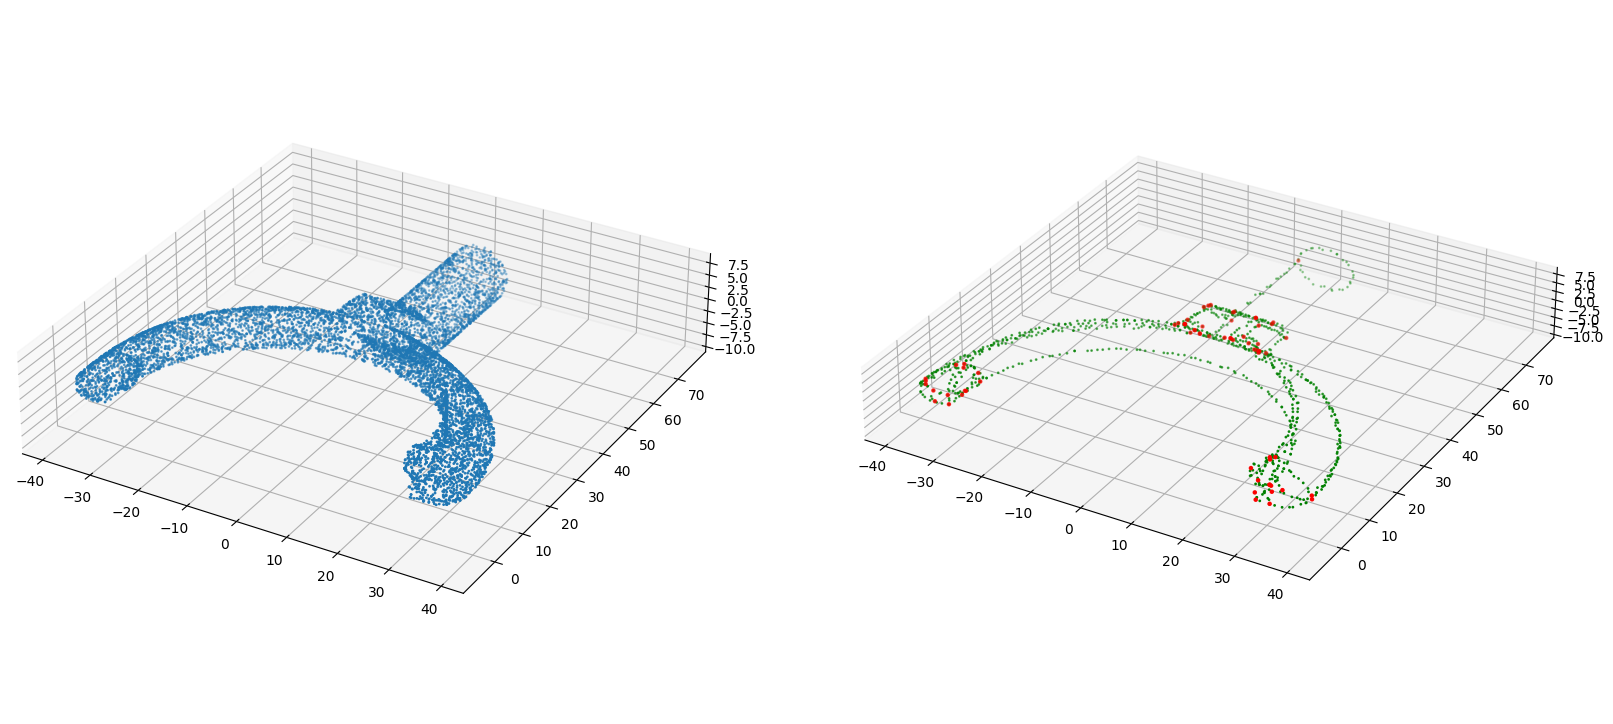

In [266]:
__, axs = plt.subplots(
    1, 2,
    figsize=(20, 10),
    subplot_kw=dict(projection="3d"))

plot_point_cloud(loaded_pcloud[["x", "y", "z"]].values, ax=axs[0])

plot_edges_and_corners(loaded_pcloud, ax=axs[1])

In [250]:
import tqdm

feat_paths_to_process = tqdm.tqdm(feat_paths)

with multiprocessing.Pool() as pool:
    pool.map(training_data.generate_one_pcloud, feat_paths_to_process, chunksize=10)

# 1.5 hrs

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7168/7168 [1:25:48<00:00,  1.39it/s]


# Point classification (+ offset regression)
TODO
- [ ] :try https://github.com/dgriffiths3/pointnet2-tensorflow2
  - [ ] if no good, *try https://github.com/charlesq34/pointnet2/pull/154
- [ ] Look at TF records API
- [ ] :check how to point cls with PointNet++
  - loss?
- [ ] :check how to corrd reg with PointNet++
  - loss?
    - maybe skip coord reg for now if adding too much complexity to the custom loss
  
CUDA TODO (ref: https://docs.nvidia.com/cuda/cuda-installation-guide-linux/contents.html#)
- [x] might need to upgrade nvidia driver to 525.60.13; UPGRADED

In [7]:
import pathlib

import tensorflow as tf

In [8]:
SCANNET_TRAIN_PATH = "pointnet2-tensorflow2/data/scannet_train.tfrecord"

In [12]:
raw_dataset = tf.data.TFRecordDataset(SCANNET_TRAIN_PATH)
raw_dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

In [14]:
for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())

In [15]:
result = {}
# example.features.feature is the dictionary
for key, feature in example.features.feature.items():
  # The values are the Feature objects which contain a `kind` which contains:
  # one of three fields: bytes_list, float_list, int64_list

  kind = feature.WhichOneof('kind')
  result[key] = np.array(getattr(feature, kind).value)

result

{'labels': array([2, 0, 2, ..., 0, 0, 0]),
 'points': array([5.87644958, 1.5794059 , 0.11046334, ..., 6.36106491, 1.37781262,
        3.06028628])}

In [17]:
result['labels'].shape

(8192,)

In [18]:
result['points'].shape

(24576,)

## Load dataset

In [23]:
PCLOUD_DIR = DATA_DIR / "pcloud"
EX_PCLOUD_PATH = PCLOUD_DIR / "00000002_pcloud_points.parq"

In [64]:
def _load_single_pcloud(path, label_type=""):
    label_col = f"is_{label_type}"
    points = (
        pd.read_parquet(path)
            .drop_duplicates(["x", "y", "z"])  # TODO shouuld keep the closest
            .assign(label=lambda df: df[label_col].astype(int))
    )
    point_coords = points[["x", "y", "z"]].values
    point_labels = points[["label"]].values
    return point_coords, point_labels

In [65]:
point_coords, point_labels = _load_single_pcloud(EX_PCLOUD_PATH, label_type="edge")

In [59]:
def load_dataset_from_dir(path, label_type="edge", n_files=None):
    paths = sorted(str(p) for p in path.glob("*.parq"))
    if n_files:
        paths = paths[:n_files]
    
    features, labels = [], []
    for path in paths:
        coords, per_pt_labels = _load_single_pcloud(path, label_type=label_type)
        features.append(coords)
        labels.append(per_pt_labels)
    
    return pd.DataFrame(dict(features=features, labels=labels))



In [60]:
dataset = load_dataset_from_dir(PCLOUD_DIR, n_files=100)
y = dataset.pop("labels")
x = dataset

In [62]:
x.features.values[0].shape

(8096, 3)

In [63]:
y.values[0].shape

(8096, 1)

# Misc